# IANNWTF - Homework 07
(by Group 17 - Nils Niehaus, Philipp Bauer, Marlon Dammann)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

## 1 Data Set

In [2]:
sequence_len = 30
num_samples = 80000

In [3]:
def integration_task(seq_len, num_samples):
  for _ in range(num_samples):
    data = np.random.normal(size=seq_len)
    target = True if np.sum(data) > 0 else False
    data = np.expand_dims(data,-1)
    target = np.expand_dims(target,-1)
    yield data, target

In [4]:
def my_integration_task():
  for data,target in integration_task(sequence_len, num_samples):
    yield data,target

In [5]:
dataset = tf.data.Dataset.from_generator(my_integration_task, 
                                         output_signature=(
                                             tf.TensorSpec(shape=(sequence_len,1), dtype = 'float32'),
                                             tf.TensorSpec(shape=(1), dtype = 'int16')))

In [6]:
train_ds = dataset.take(int(num_samples*0.7))
dataset = dataset.skip(int(num_samples*0.7))

test_ds = dataset.take(int(num_samples*0.2))
dataset = dataset.skip(int(num_samples*0.2))

valid_ds = dataset.take(int(num_samples*0.1))
dataset = dataset.skip(int(num_samples*0.1))

In [7]:
def preprocess_dataset(dataset):
  dataset = dataset.cache()
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(128)
  dataset = dataset.prefetch(60)
  return dataset

In [8]:
train_ds = preprocess_dataset(train_ds)
test_ds = preprocess_dataset(test_ds)
valid_ds = preprocess_dataset(valid_ds)

## 2 Model

In [9]:
class LSTM_Cell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTM_Cell, self).__init__()
        self.units = units
        self.forget_gate = tf.keras.layers.Dense(units, activation='sigmoid', bias_initializer='ones')
        self.input_gate = tf.keras.layers.Dense(units, activation='sigmoid')
        self.output_gate = tf.keras.layers.Dense(units, activation='sigmoid')
        self.cell = tf.keras.layers.Dense(units, activation='tanh')
    
    def call(self, x, states):
        hidden_state = states[0]
        cell_state = states[1]
        xh = tf.concat([x, hidden_state], axis=1)

        cell_state = tf.math.multiply(self.forget_gate(xh), cell_state) + tf.math.multiply(self.input_gate(xh), self.cell(x))
        hidden_state = tf.math.multiply(self.output_gate(xh),tf.nn.tanh(cell_state))

        return hidden_state, cell_state

In [10]:
class LSTM_Layer(tf.keras.layers.Layer):
    def __init__(self, cell):
      super(LSTM_Layer, self).__init__()
      self.cell = cell

    @tf.function
    def call(self, x, states=None):
      batch_size = tf.shape(x)[0]
      sequence_length = tf.shape(x)[1]
      if not states:
          states = self.zero_states(batch_size)
      output_sequence = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
      for seq_idx in tf.range(sequence_length):
        input = x[:, seq_idx]
        states = self.cell(input, states)
        output_sequence = output_sequence.write(seq_idx, states[0])
      output_sequence = tf.transpose(output_sequence.stack(), perm=[1,0,2])
      return output_sequence

    def zero_states(self, batch_size):
        return (tf.zeros((batch_size, self.cell.units)), tf.zeros((batch_size, self.cell.units)))

In [11]:
class LSTM_Model(tf.keras.Model):
    def __init__(self):
      super(LSTM_Model, self).__init__()
      self.input_layer = tf.keras.layers.Dense(30, activation='sigmoid')
      self.lstm = LSTM_Layer(LSTM_Cell(8))
      self.dense = tf.keras.layers.Dense(3, activation='sigmoid')
      self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
      x = self.input_layer(x)
      x = self.lstm(x)
      x = self.dense(x)
      x = self.output_layer(x)
      return x[:,-1,:]


## 3 Training

In [12]:
model_performance = {'training': {'loss' : [], 'accuracy' : []}, 
                     'test': {'loss' : [], 'accuracy' : []},
                     'valid': {'loss' : [], 'accuracy' : []}}

In [13]:
ds = {'training' : train_ds, 'test' : test_ds, 'valid' : valid_ds}

In [14]:
def get_loss_and_accuracy(model, data_split, loss_function, mode_name):
    '''Returns the loss and accuracy of the model on a given split of the data.'''
    accuracy_aggregator = []
    loss_aggregator = []

    for (input, target) in tqdm(data_split,desc='Sampling Loss/Accuracy for ' + str(mode_name) + ' data'):
        prediction = model(input)
        sample_loss = loss_function(target, prediction)
        sample_accuracy =  np.round(target) == np.round(prediction)
        loss_aggregator.append(sample_loss.numpy())
        accuracy_aggregator.append(np.mean(sample_accuracy))
        
    loss = tf.reduce_mean(loss_aggregator)
    accuracy = tf.reduce_mean(accuracy_aggregator)
    return loss, accuracy

In [15]:
def performance_test(model, data_split, loss_function, model_performance, mode_name):
    '''Evaluation of loss and accuracy of a model on a data split.'''
    loss, accuracy = get_loss_and_accuracy(model, data_split, loss_function, mode_name)
    model_performance[mode_name]['loss'].append(loss.numpy())
    model_performance[mode_name]['accuracy'].append(accuracy.numpy())

In [16]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [17]:
def train_model(model, dataset, optimizer, loss_function, num_epochs, model_performance):
    
    '''Initial performance of the model without training'''
    for data, name in zip(list(dataset.values()),list(dataset.keys())):
        performance_test(model, data, loss_function, model_performance, mode_name=name)
    
    for epoch in range(num_epochs):
        for input,target in tqdm(dataset['training'],desc='Epoch '+str(epoch+1)):
            train_step(model, input, target, loss_function, optimizer)
        for data, name in zip(list(dataset.values()),list(dataset.keys())):
            performance_test(model, data, loss_function, model_performance, mode_name=name)

In [18]:
tf.keras.backend.clear_session()

'''Hyperparameters'''
num_epochs = 10
learning_rate = 0.001

'''Loss function'''
loss_func = tf.keras.losses.BinaryCrossentropy()

'''Adam as chosen optimizer'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

'''Model'''
model = LSTM_Model()

In [19]:
train_model(model, ds, optimizer, loss_func, num_epochs, model_performance)

Sampling Loss/Accuracy for training data: 438it [00:30, 14.42it/s]
Sampling Loss/Accuracy for test data: 125it [00:18,  6.76it/s]
Sampling Loss/Accuracy for valid data: 63it [00:18,  3.44it/s]
Epoch 1: 438it [00:26, 16.23it/s]
Sampling Loss/Accuracy for training data: 438it [00:06, 64.80it/s]
Sampling Loss/Accuracy for test data: 125it [00:02, 49.02it/s]
Sampling Loss/Accuracy for valid data: 63it [00:00, 64.59it/s]
Epoch 2: 438it [00:40, 10.70it/s]
Sampling Loss/Accuracy for training data: 438it [00:06, 64.78it/s]
Sampling Loss/Accuracy for test data: 125it [00:02, 49.05it/s]
Sampling Loss/Accuracy for valid data: 63it [00:00, 64.67it/s]
Epoch 3: 438it [00:26, 16.61it/s]
Sampling Loss/Accuracy for training data: 438it [00:06, 64.77it/s]
Sampling Loss/Accuracy for test data: 125it [00:02, 49.01it/s]
Sampling Loss/Accuracy for valid data: 63it [00:01, 61.67it/s]
Epoch 4: 438it [00:26, 16.39it/s]
Sampling Loss/Accuracy for training data: 438it [00:06, 64.34it/s]
Sampling Loss/Accuracy fo

In [20]:
model.summary()

Model: "lstm__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  60        
                                                                 
 lstm__layer (LSTM_Layer)    multiple                  1184      
                                                                 
 dense_5 (Dense)             multiple                  27        
                                                                 
 dense_6 (Dense)             multiple                  4         
                                                                 
Total params: 1,275
Trainable params: 1,275
Non-trainable params: 0
_________________________________________________________________


## 4 Visualization

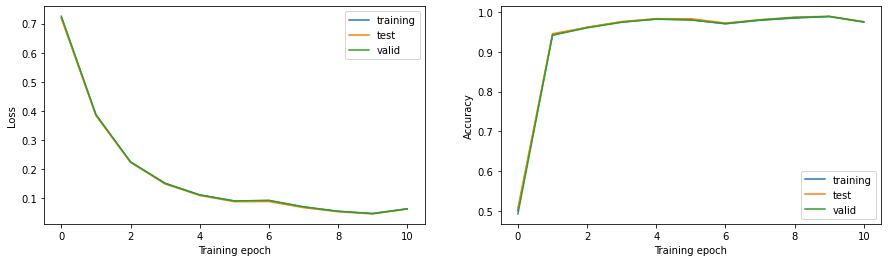

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15, 4))
line1, = ax[0].plot(model_performance['training']['loss'])
line2, = ax[0].plot(model_performance['test']['loss'])
line3, = ax[0].plot(model_performance['valid']['loss'])
line4, = ax[1].plot(model_performance['training']['accuracy'])
line5, = ax[1].plot(model_performance['test']['accuracy'])
line6, = ax[1].plot(model_performance['valid']['accuracy'])
ax[0].set_xlabel("Training epoch")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Training epoch")
ax[1].set_ylabel("Accuracy")
ax[0].legend((line1,line2,line3),("training","test", 'valid'))
ax[1].legend((line4,line5,line6),("training","test", 'valid'))
plt.show()